In [1]:
#!pip install Pillow
#!pip install fpdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math

#załadowanie plików do odczytu przez windows explorer
import tkinter as tk
from tkinter import filedialog
import os
from pathlib import Path

#zapis do pdfu z listy figs
from matplotlib.backends.backend_pdf import PdfPages

#pozwala wytworzyć colorlabel przy mapach, gdy uzwyamy ax[i,j] 
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#funckja usuwająca zbędne komórki w dataframe
def clean(df):
    df = df.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]).reset_index(drop = True)
    return df
#funckja tworząca data frame
def make_df(file):
    df = pd.read_table(file,header = None)
    df = df.drop([0,1,2,3,4,5,6,7,10,15,16]).reset_index(drop = True)
    return df

#funckja wydobywa ze ścieżki do folderu numer próbki
def number(Hist_dir):
    counter=0
    lista=list()
    for i in str(Hist_dir):
        if i.isdigit() and counter<4:
            lista.append(i)
            counter+=1
    return "".join(lista)  

#funckja wyciąga ścięzke do pliku bez elementu WindowsPath gdy uzywamy import os oraz from pathlib import Path
def path(files):
    files2=list()
    for i in files:
        files2.append(str(i))
    return files2

#funckja zmieniająca kształt tabeli z trzech kolumn X Y Z na iloczyn X*Y bez powtorzen
def df_reshape(lista):
    columns = ["Axis X", "Axis Y", "Value"]
    a=pd.DataFrame(lista, columns=columns)
    X = a.iloc[:,0]
    Y = a.iloc[:,1]
    Z = a.iloc[:,2]
# Reshape data    
    df = pd.DataFrame(np.column_stack([X, Y, Z]), columns=list('XYZ'))
    df = df.pivot(index='Y', columns='X', values='Z')
    return df
#rysowanie wykresów dla przypadku, gdy nie mamy mapy
def figures_one_line(df,nazwa,i,j):
    ax[i,j].plot(df.columns, df.iloc[0,:])
    ax[i,j].set_xlabel("Position [mm]",fontsize=font)
    ax[i,j].set_ylabel(f'{nazwa}',fontsize=font)
    ax[i,j].minorticks_on()
    ax[i,j].tick_params(axis="both", which = "major", length=10, direction ="in",labelsize=10)
    ax[i,j].tick_params(axis="both", which = "minor", length=5, direction ="in")

In [31]:
#załadowanie plików do odczytu przez windows explorer

root = tk.Tk()
root.withdraw() #funkcja nie pozwalająca na wykoakiwanie okienka

#files = filedialog.askopenfilenames() #otwiera bezpośrednio pliki
Hist_dir = filedialog.askdirectory()  #otwiera folder z plikami

files = path(sorted(Path(Hist_dir).iterdir(), key=os.path.getmtime))

In [32]:
%%capture   
#funkcja magiczna nie pozwalająca wyświetlać outputu całej komórki. !!! ważne musi być zastosowana w pierwszej linii komórki
coercive=[]
coercive_sign=[]
remanence=[]
saturation=[]
mr_to_ms=[]
ncols=4
nrows=5
counter=0
Errors =[]
font=10
plt.rcParams["figure.figsize"] = (12,10)
for k in np.arange(math.ceil(len(files)/(ncols*nrows))):
    try:
    
        fig, ax = plt.subplots(nrows, ncols,constrained_layout=True)
#fig, ax = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row')        
        for i in np.arange(nrows):
            for j in np.arange(ncols):
                df= make_df(files[counter])
                ax[i,j].plot(df.iloc[6:,0].astype(float),df.iloc[6:,1].astype(float),"r")
                ax[i,j].set_title(f"x = {float(df.iloc[0,1])} mm, y = {float(df.iloc[1,1])} mm",fontsize=font)
                ax[i,j].set_xlabel("H [kOe]",fontsize=font)
                ax[i,j].set_ylabel("Kerr signal [a.u.]",fontsize=font)
                ax[i,j].minorticks_on()
                ax[i,j].tick_params(axis="both", which = "major", length=10, direction ="in",labelsize=10)
                ax[i,j].tick_params(axis="both", which = "minor", length=5, direction ="in")
                counter += 1
                if df[6:].astype(float).sort_values(by=0, ascending=True).reset_index(drop=True).iloc[0,1]>0:
                    sign = -1
                else:
                    sign = 1
                coercive_sign.append([float(df.iloc[0,1]),float(df.iloc[1,1]),float(df.iloc[4,1])*sign])
                coercive.append([float(df.iloc[0,1]),float(df.iloc[1,1]),float(df.iloc[4,1])])
                remanence.append([float(df.iloc[0,1]),float(df.iloc[1,1]),float(df.iloc[2,1])])
                saturation.append([float(df.iloc[0,1]),float(df.iloc[1,1]),float(df.iloc[3,1])])
                mr_to_ms.append([float(df.iloc[0,1]),float(df.iloc[1,1]),float(df.iloc[2,1])/float(df.iloc[3,1])])
    except IndexError:
        Errors.append((i,j))
        
               
#zapis wszystkich plotow do listy. 1 element listy to wszystkie ploty dla danego k
figs = list(map(plt.figure, plt.get_fignums()))


df_coercive = df_reshape(coercive)
df_coercive_sign = df_reshape(coercive_sign)
df_remanence = df_reshape(remanence)
df_saturation = df_reshape(saturation)
df_mr_to_ms = df_reshape(mr_to_ms)

In [33]:
%%capture
error_profiles =[]
lista = [(df_coercive, "Coercive field [kOe]"), (df_remanence, "Remanence [a.u.]"),(df_saturation, "Saturation [a.u.]"), (df_mr_to_ms,"mr/ms")]
ncols= 1 if df_coercive.shape[0]==1 else 4
nrows=math.ceil(df_coercive.shape[0]/ncols)
plt.rcParams['figure.figsize'] = [12, 10]
font = 10
if ncols==1:
    fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
    figures_one_line(df_coercive,"Coercive field [kOe]",0,0)
    figures_one_line(df_remanence,"Remanence [a.u.]",0,1)
    figures_one_line(df_saturation,"Saturation [a.u.]",1,0)
    figures_one_line(df_mr_to_ms,"MR / MS",1,1)
else:
    try:    
        for k in np.arange(4):
            counter = 0
            fig, ax = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True)
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    ax[i,j].plot(lista[k][0].columns, lista[k][0].iloc[counter,:])
                    ax[i,j].set_title(f" y = {df_coercive.index[counter]} mm",fontsize=font)
                    ax[i,j].set_xlabel("Position [mm]",fontsize=font)
                    ax[i,j].set_ylabel(lista[k][1],fontsize=font)
                    ax[i,j].minorticks_on()
                    ax[i,j].tick_params(axis="both", which = "major", length=10, direction ="in",labelsize=10)
                    ax[i,j].tick_params(axis="both", which = "minor", length=5, direction ="in")
                    counter += 1
    except IndexError:
        error_profiles.append([lista[k][1],i,j])
    
#zapis wszystkich plotow do listy. 1 element listy to wszystkie ploty dla danego k
figs2 = list(map(plt.figure, plt.get_fignums()))

In [34]:
%%capture
counter = 0
lista = [(df_coercive_sign, "seismic", "Coercive field [kOe]"), (df_remanence,'nipy_spectral', "Remanence [a.u.]"), 
                                                            (df_saturation,'nipy_spectral', "Saturation [a.u.]"), (df_mr_to_ms,'nipy_spectral', "mr/ms")]
plt.rcParams['figure.figsize'] = [12, 10]
fig, ax = plt.subplots(2, 2,constrained_layout=True)
font = 20

for i in np.arange(0,2):
    for j in np.arange(0,2):
        im = ax[i,j].imshow(lista[counter][0], cmap=lista[counter][1], interpolation='gaussian')
        #poniżej, trzy linie tworzą colorlabel ale przy ax[i,j]
        divider = make_axes_locatable(ax[i,j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        
        ax[i,j].set_title(lista[counter][2],fontsize=font)
        ax[i,j].set_xlabel("H [kOe]",fontsize=font)
        ax[i,j].set_ylabel("Kerr signal [a.u.]",fontsize=font)
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(axis="both", which = "major", length=20, direction ="in",labelsize=20, color='white' )
        ax[i,j].tick_params(axis="both", which = "minor", length=10, direction ="in",color='white')
        ax[i,j].set_ylim(ax[i,j].get_ylim()[::-1]) # odwrocenie osi
        fig.colorbar(im, cax=cax, orientation='vertical')
        counter += 1
#zapis wszystkich plotow do listy. 1 element listy to wszystkie ploty dla danego k
figs3 = list(map(plt.figure, plt.get_fignums()))

In [35]:
#zapis do pdfu z listy figs+figs2

#pp = PdfPages('test.pdf')
pp = PdfPages(f'{number(files)}_1V_kuswik.pdf')
for image in figs+figs2+figs3:
    pp.savefig(image)
pp.close()

In [ ]:
#załadowane dane łączy w jeden DataFrame
df = pd.concat(list(pd.read_table(f,header = None) for f in files),axis=1)
#wyrzucenie zbędnych wierszy
df = df.drop([0,1,2,3,4,5,6,7,10,15,16]).reset_index(drop = True)

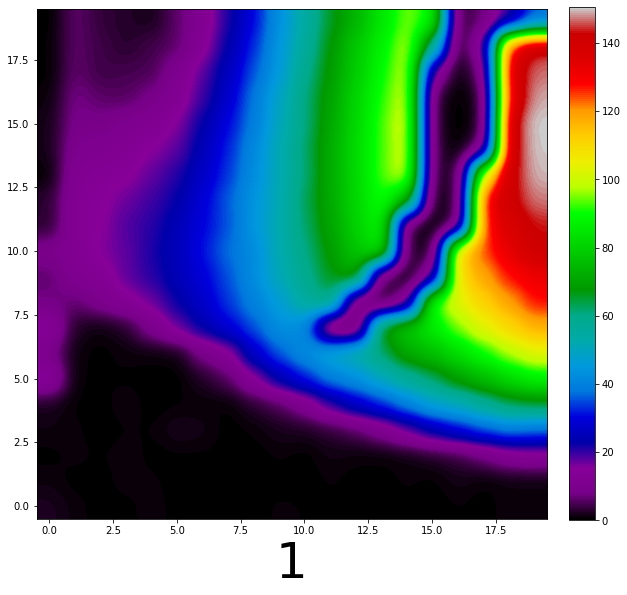

In [11]:
kolory = ['viridis', 'plasma', 'inferno', 'magma', 'cividis','Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd',
 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn','BuGn', 'YlGn','binary', 'gist_yarg', 'gist_gray', 'gray', 'bone','pink', 'spring',
 'summer', 'autumn', 'winter', 'cool', 'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu',
'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic','twilight', 'twilight_shifted', 'hsv','Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b','tab20c','flag', 'prism', 'ocean', 'gist_earth', 'terrain','gist_stern', 'gnuplot', 
'gnuplot2', 'CMRmap','cubehelix', 'brg', 'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral', 'gist_ncar']

plt.imshow(df_remanence, cmap='nipy_spectral',interpolation='gaussian')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(i,fontsize=50)
plt.gca().invert_yaxis()  #odwraca oś Y
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()


In [14]:
import Image
import ImageTk
import Tkinter

image_list = figs
current = 0

def move(delta):
    global current, image_list
    if not (0 <= current + delta < len(image_list)):
        tkMessageBox.showinfo('End', 'No more image.')
        return
    current += delta
    image = Image.open(image_list[current])
    photo = ImageTk.PhotoImage(image)
    label['image'] = photo
    label.photo = photo


root = Tkinter.Tk()

label = Tkinter.Label(root, compound=Tkinter.TOP)
label.pack()

frame = Tkinter.Frame(root)
frame.pack()

Tkinter.Button(frame, text='Previous picture', command=lambda: move(-1)).pack(side=Tkinter.LEFT)
Tkinter.Button(frame, text='Next picture', command=lambda: move(+1)).pack(side=Tkinter.LEFT)
Tkinter.Button(frame, text='Quit', command=root.quit).pack(side=Tkinter.LEFT)

move(0)

root.mainloop()

ModuleNotFoundError: No module named 'Image'

In [15]:
!pip install pillow

In [20]:
import tkinter

from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure

import numpy as np


root = tkinter.Tk()
root.wm_title("Embedding in Tk")

#fig = Figure(figsize=(5, 4), dpi=100)
#t = np.arange(0, 3, .01)
#fig.add_subplot(111).plot(t, 2 * np.sin(2 * np.pi * t))
def hue():
    
    canvas = FigureCanvasTkAgg(figs[0], master=root)  # A tk.DrawingArea.
    canvas.draw()
    canvas.get_tk_widget().pack(side=tkinter.TOP, fill=tkinter.BOTH, expand=1)

    toolbar = NavigationToolbar2Tk(canvas, root)
    toolbar.update()
    canvas.get_tk_widget().pack(side=tkinter.TOP, fill=tkinter.BOTH, expand=1)


    def on_key_press(event):
        print("you pressed {}".format(event.key))
        key_press_handler(event, canvas, toolbar)


    canvas.mpl_connect("key_press_event", on_key_press)


def _quit():
    root.quit()     # stops mainloop
    root.destroy()  # this is necessary on Windows to prevent
                    # Fatal Python Error: PyEval_RestoreThread: NULL tstate

mybutton = tkinter.Button(root, text='MAIN',command = hue).pack()
button = tkinter.Button(master=root, text="Quit", command=_quit)
button.pack(side=tkinter.BOTTOM)

tkinter.mainloop()
# If you put root.destroy() here, it will cause an error if the window is
# closed with the window manager.

In [24]:
files

['C:\\Users\\Frącek\\Desktop\\PyHist\\Nowy folder\\1v\\6635\\6635_256_05V_19mm\\pol_rot_p_0000_0000_0',
 'C:\\Users\\Frącek\\Desktop\\PyHist\\Nowy folder\\1v\\6635\\6635_256_05V_19mm\\pol_rot_p_0005_0000_1',
 'C:\\Users\\Frącek\\Desktop\\PyHist\\Nowy folder\\1v\\6635\\6635_256_05V_19mm\\pol_rot_p_0010_0000_2',
 'C:\\Users\\Frącek\\Desktop\\PyHist\\Nowy folder\\1v\\6635\\6635_256_05V_19mm\\pol_rot_p_0015_0000_3',
 'C:\\Users\\Frącek\\Desktop\\PyHist\\Nowy folder\\1v\\6635\\6635_256_05V_19mm\\pol_rot_p_0020_0000_4',
 'C:\\Users\\Frącek\\Desktop\\PyHist\\Nowy folder\\1v\\6635\\6635_256_05V_19mm\\pol_rot_p_0025_0000_5',
 'C:\\Users\\Frącek\\Desktop\\PyHist\\Nowy folder\\1v\\6635\\6635_256_05V_19mm\\pol_rot_p_0030_0000_6',
 'C:\\Users\\Frącek\\Desktop\\PyHist\\Nowy folder\\1v\\6635\\6635_256_05V_19mm\\pol_rot_p_0035_0000_7',
 'C:\\Users\\Frącek\\Desktop\\PyHist\\Nowy folder\\1v\\6635\\6635_256_05V_19mm\\pol_rot_p_0040_0000_8',
 'C:\\Users\\Frącek\\Desktop\\PyHist\\Nowy folder\\1v\\6635\\663

In [62]:
a = pd.read_table('Sygnał CAŁY.txt')
b = pd.read_table('Hc duże.txt')
a.head()

,Unnamed: 0,0.,1.,2.,3.,4.,5.,6.,7.,8.,...,12.,13.,14.,15.,16.,17.,18.,19.,20.,Unnamed: 22
0,0.0,2.73355,19.2357,21.4623,42.9273,60.5414,76.4331,95.5706,114.199,134.650,...,219.790,237.102,249.756,262.813,271.526,276.385,283.267,289.644,NaN,NaN
1,1.0,348.46600,362.2350,345.2230,358.5880,347.2510,350.6950,355.7540,131.916,364.666,...,314.857,323.965,148.010,125.637,297.442,230.419,312.524,205.924,NaN,NaN
2,2.0,NaN,332.2720,206.9320,130.8010,254.8200,419.1320,443.1240,451.632,445.350,...,387.646,368.410,349.074,323.055,306.250,287.824,276.484,256.741,NaN,NaN
3,3.0,756.96900,733.7850,704.3230,674.7610,646.5150,612.6990,572.2030,530.393,514.395,...,363.856,350.794,322.853,303.822,290.860,283.978,277.803,263.734,NaN,NaN
4,4.0,773.36800,749.0680,717.6860,684.3790,652.5880,619.2810,584.6580,546.794,504.169,...,332.168,297.845,288.331,289.238,281.242,279.628,274.668,260.090,NaN,NaN


In [34]:
a.iloc[2,0]

1.0

In [15]:
for i in a['Unnamed: 0']:
    print (i)

0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
10.5
11.0
11.5
12.0
12.5
13.0
13.5
14.0
14.5
15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0


In [63]:
lista = []

for i in a.index:
    for j in np.arange(1,21):
        lista.append([a.iloc[i,0],j-1,b.iloc[i,j],a.iloc[i,j]/2])

In [46]:
pd.DataFrame(lista).to_csv('6810_poprawka.csv')

In [64]:
c = pd.DataFrame(lista)
c.columns = ['x','y','Hc','Remanence']

In [65]:
c.sort_values(by=['y','x'],axis=0,inplace=True)

In [66]:
c.to_excel('5776_poprawka.xls')

C:\Users\FRCEK~1\AppData\Local\Temp/ipykernel_17792/3562027895.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  c.to_excel('5776_poprawka.xls')


In [82]:
a = pd.read_excel('6810_final.xlsx')
lista6810 = a.iloc[:,0:5]
lista5776 = a.iloc[:,13:18]
lista5776.columns = ['x','y','Hc','Remanence','Saturation']

In [77]:
a

,x,y,Hc,Remanence,Saturacja,6710,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,5776,x.1,y.1,Hc.1,Remanence.1,Saturation
0,0.0,0,310.000,57.3025,57.3025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1,0.5,0,311.925,60.7430,60.7430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.000,0.0000,176.0000
2,1.0,0,310.775,60.5400,60.5400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,1.000,0.0000,268.0000
3,1.5,0,334.075,59.9350,59.9350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,459.050,378.4845,378.4845
4,2.0,0,310.350,59.8395,59.8395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,683.725,386.6840,386.6840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,17.0,19,1775.350,166.4370,166.4370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
776,17.5,19,1464.230,171.0920,171.0920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777,18.0,19,1273.300,173.4220,173.4220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
778,18.5,19,1077.030,182.6355,182.6355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
lista6810

,x,y,Hc,Remanence,Saturacja
0,0.0,0,310.000,57.3025,57.3025
1,0.5,0,311.925,60.7430,60.7430
2,1.0,0,310.775,60.5400,60.5400
3,1.5,0,334.075,59.9350,59.9350
4,2.0,0,310.350,59.8395,59.8395
...,...,...,...,...,...
775,17.0,19,1775.350,166.4370,166.4370
776,17.5,19,1464.230,171.0920,171.0920
777,18.0,19,1273.300,173.4220,173.4220
778,18.5,19,1077.030,182.6355,182.6355


In [91]:
def df_reshape(lista):
    columns = ["X", "Y", "Coercive"]
    lista.columns = columns
    X = a.iloc[:,0]
    Y = a.iloc[:,1]
    Z = a.iloc[:,2]
# Reshape data    
    df = pd.DataFrame(np.column_stack([X, Y, Z]), columns=list('XYZ'))
    df = df.pivot(index='X', columns='Y', values='Z')
    return df

In [95]:
coercive6810 = df_reshape(lista6810.iloc[:,:3])

In [96]:
coercive6810

Y,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
X,,,,,,,,,,,,,,,,,,,,
0.0,310.000,865.250,1030.050,1133.150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.5,311.925,883.100,1172.900,1417.180,1663.150,2022.050,2576.030,3187.500,3911.430,4644.880,5024.530,5166.80,5228.930,5197.230,5160.400,5091.13,4929.13,4919.580,NaN,NaN
1.0,310.775,933.925,1273.230,1612.750,2051.080,2505.450,3053.650,3588.400,4100.830,4375.380,4369.380,4206.38,4109.600,3984.700,3904.880,3787.60,3761.80,3751.680,5000.000,NaN
1.5,334.075,988.475,1266.550,1660.600,2146.050,2732.780,3485.900,3778.080,4118.770,4103.900,3903.900,3681.48,3490.600,3296.330,3169.830,3083.05,3039.35,3073.530,3265.200,NaN
2.0,310.350,979.350,1326.580,1763.400,2349.130,3022.830,3855.970,4221.200,4384.680,4270.550,3847.980,3508.30,3202.030,3036.530,2875.200,2764.08,2685.98,2708.630,2928.150,NaN
2.5,304.600,985.775,1347.630,1781.450,2444.880,3318.230,4342.330,4984.130,5251.800,4991.350,4449.480,4000.75,3628.080,3348.480,3102.180,2992.10,2888.18,2830.930,2970.050,NaN
3.0,304.650,985.275,1369.800,1853.900,2541.400,3599.230,5038.180,6222.070,6748.700,6455.330,5875.550,5240.00,4816.400,4531.900,4196.230,3979.40,3781.93,3610.280,3654.600,NaN
3.5,309.025,985.450,1446.330,1952.380,2736.750,4002.880,5971.750,7933.700,8691.950,8141.530,7523.030,6984.38,6515.830,6155.700,5871.100,5586.52,5409.38,5191.000,96.225,NaN
4.0,307.500,1078.730,1464.400,2050.630,2933.730,4384.330,7044.100,10039.600,10377.400,9816.130,9250.000,8695.42,8255.800,7994.400,7637.580,7488.60,NaN,NaN,NaN,NaN
